# Tests on Trans Atlas data

Trajectories from the TransAtlas MD database are used here as input data. These trajectories reproduce conformational transitions between two different states of proteins. The trajectories are generated using the GOdMD approach. The potential energy function considers only Carbon alpha atoms and both bonding and non-bonding interactions are described with simplified wells. The MD engine to generate samples uses discrete MD (ballistic regime) and enhanced sampling with metadynamics and Maxwell Demon. For additional details see [Orozco et al.](https://doi.org/10.1093/bioinformatics/btt324).

Thus these trajectories represent large conformational changes of proteins. They contain only Carbon alpha atoms and there is a small number of samples. Here we will use the deep cartograph package to analyze these trajectories and find collective variables that describe the transitions.

In [1]:
from deep_cartograph.modules.plumed.utils import read_as_pandas
from deep_cartograph.run import deep_cartograph 
import importlib.resources as resources
from deep_cartograph import data

from sklearn.neighbors import KernelDensity
from IPython.display import display, HTML
from typing import Tuple, Dict, List, Literal
import matplotlib.pyplot as plt
from decimal import Decimal
import pandas as pd
import numpy as np
import logging
import shutil
import yaml
import time
import os

# Get the path to the data
data_folder = resources.files(data)

# Set logging level
logging.basicConfig(level=logging.INFO)

def run_deep_cartograph(features: Literal['torsions', 'distances'], system_name: str):

    # Input trajectory and topology
    input_path = f"{data_folder}/calpha_transitions/input/{system_name}"
    traj_path = os.path.join(input_path, f'{system_name}.dcd')
    top_path = os.path.join(input_path, f'{system_name}.pdb')

    # Input configuration
    config_path = f"{data_folder}/calpha_transitions/input/{features}_config.yml"
    with open(config_path) as config_file:
        configuration = yaml.load(config_file, Loader = yaml.FullLoader)

    # Output folder for the full workflow
    output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"

    # Clean output folder
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    ################
    # Run workflow #
    ################
    deep_cartograph(
        configuration = configuration,
        trajectory = traj_path,
        topology = top_path,
        output_folder = output_folder)

def compute_kde(feature_data: pd.DataFrame, bandwidth: float = 0.1, kernel: str = "gaussian") -> KernelDensity:
    """
    Compute the Kernel Density Estimation for a data frame containing the time series of a single feature.

    Parameters
    ----------

        feature_data    (pandas DataFrame):   data frame with the time series of a single feature
        bandwith        (float):              bandwith for the KDE
        kernel          (str):                kernel for the KDE
    
    Returns
    -------

        kde             (KernelDensity):       KDE object
    """

    # Create the KDE object
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)

    # Convert the data to a numpy array
    data = feature_data.values.reshape(-1, 1)

    # Fit the KDE
    kde.fit(data)

    return kde

def show_filtering_results(colvars_path: str, filter_summary_path: str, N: int = 10, bandwidth: float = 0.1, kernel: str = "gaussian", alpha_level = 0.05):
    """
    Function that shows a summary of the feature analysis. It shows:
     
       - The probability distribution of N randomly selected discarded features and N randomly selected filtered features. 
       - The distribution of the hartigan dip test (hdt) result for all the features
    
    Parameters
    ----------
    
        colvars_path        (str): path to the colvars file with the time series of all features
        filter_summary_path (str): path to the filter summary csv file with the results of the filter for each feature
        N                   (int): number of features to show
        bandwidth           (float): bandwidth for the KDE
        kernel              (str): kernel for the KDE
        alpha_level         (float): alpha level used for the hartigan dip test
    """

    font_size = 14
    
    def get_kde_models(colvars_df: pd.DataFrame, names: list, bandwidth: float = 0.1, kernel: str = "gaussian") -> Tuple[Dict, List]:
        """
        Get the KDE models for each feature in the list of names together with the maximum and minimum values across all features (to use as x-axis limits if needed)

        Parameters
        ----------

            colvars_df  (pandas DataFrame):   data frame with the time series of all features
            names       (list):                list of feature names
            bandwidth   (float):               bandwidth for the KDE
            kernel      (str):                 kernel for the KDE

        Returns
        -------

            kde_models  (dict):                dictionary with the KDE models for each feature
            features_range (list):             list with the maximum and minimum values across all features
        """
        
        kde_models = {}
        features_range = [colvars_df[names[0]].min(), colvars_df[names[0]].max()]
        for name in names:
            feature_data = colvars_df[name]
            kde = compute_kde(feature_data, bandwidth = bandwidth, kernel = kernel)
            kde_models[name] = kde
            features_range[0] = min(features_range[0], feature_data.min())
            features_range[1] = max(features_range[1], feature_data.max())
        
        return kde_models, features_range

    def plot_kde(data_df: pd.DataFrame, bandwidth: float = 0.01, kernel: str = "gaussian", x_label: str = "x", title: str = "KDE"):
        """
        Plot the Kernel Density Estimation of a data frame with a single feature

        Parameters
        ----------

            data_df     (pandas DataFrame):   data frame with the feature values
            bandwidth   (float):               bandwidth for the KDE
            kernel      (str):                 kernel for the KDE
            x_label     (str):                 label for the x-axis
            title       (str):                 title for the plot
        """

        # Get the KDE model of the p-values
        hdtp_kde = compute_kde(data_df, bandwidth = bandwidth, kernel = kernel)

        # Generate x values to plot the KDE
        x = np.linspace(data_df.min(), data_df.max(), 1000)

        # Generate samples from the KDE model, compute the log density
        log_dens = hdtp_kde.score_samples(x[:, None])

        # Find the probability density
        dens = np.exp(log_dens)

        # Normalize the probability density
        dens = dens / dens.sum()

        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the KDE
        ax.plot(x, dens)

        # Create a new axis on the right side for the histogram
        ax_hist = ax.twinx()

        # Plot the 1D histogram of the p-values
        ax_hist.hist(data_df, bins=200, density=True, alpha=0.2)

        # Add vertical line at alpha_level
        ax.axvline(x=alpha_level, color='r', linestyle='--')

        # Add text with the alpha level
        ax.text(alpha_level, max(dens) * 0.9, f" alpha = {alpha_level}", color='r', fontsize = font_size)

        # Set size to tick labels
        ax.tick_params(axis='both', which='major', labelsize=font_size)
        ax_hist.tick_params(axis='both', which='major', labelsize=font_size)
        
        # Add limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, max(dens) + max(dens) * 0.1])

        # Add title
        ax.set_title(title, fontsize = font_size + 4)

        # Add labels
        ax.set_xlabel(x_label, fontsize = font_size)
        ax.set_ylabel("Probability density", fontsize = font_size)
        ax_hist.set_ylabel("Histogram", fontsize = font_size)

        # Show the plot
        plt.show()

    def plot_feature_kdes(features_range: List, summary_df: pd.DataFrame, kde_models: Dict[str, KernelDensity], title: str):
        """
        Plot the estimated probability distribution of the features using the KDE models. Add the p-value of the Hartigan's Dip Test 
        to the legend of each feature.

        Parameters
        ----------

            features_range  (list):               list with the maximum and minimum values across all features
            summary_df       (pandas DataFrame):  data frame with the sumary of the filter for the features (containing the name and the p-value of the Hartigan's Dip Test)
            kde_models      (dict):               dictionary with the KDE models for each feature
            title           (str):                title for the plot
        """
        
        sample_names = summary_df["name"].values

        # Generate x values to plot the KDEs
        x = np.linspace(features_range[0], features_range[1], 1000)

        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the probability distribution of each feature
        max_density = 0
        for name in sample_names:
            
            # Get the p-value of the Hartigan's Dip Test
            p_value = summary_df[summary_df["name"] == name]["hdtp"].values[0]

            # Get the corresponding KDE model
            kde_model = kde_models[name]

            # Generate samples from the KDE model, compute the log density 
            log_dens = kde_model.score_samples(x[:, None])

            # Plot the KDE
            ax.plot(x, np.exp(log_dens), label=f"{name} (p-value: {Decimal(p_value):.2E})")

            # Get the maximum density
            max_density = max(max_density, np.exp(log_dens).max())

        # Set the limits
        plt.xlim(features_range) 
        plt.ylim([0, max_density + max_density * 0.1])
        
        # Add title
        ax.set_title(title, fontsize = font_size + 4)

        # Add labels
        ax.set_xlabel("Feature value", fontsize = font_size)
        ax.set_ylabel("Probability density", fontsize = font_size)

        # Add legend
        ax.legend(fontsize = font_size - 2)

        # Set size to tick labels
        ax.tick_params(axis='both', which='major', labelsize=font_size)

        # Adjust the spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

    # Try to load the colvars file
    if not os.path.exists(colvars_path):
        raise FileNotFoundError(f"File {colvars_path} not found")
    try:
        colvars_df = read_as_pandas(colvars_path)
    except:
        raise ValueError(f"Could not read file {colvars_path}")

    # Try to load the filter summary file
    if not os.path.exists(filter_summary_path):
        raise FileNotFoundError(f"File {filter_summary_path} not found")
    try:
        filter_summary_df = pd.read_csv(filter_summary_path)
    except:
        raise ValueError(f"Could not read file {filter_summary_path}")

    # Plot the KDE of the Hartigan Dip Test p-values for the features
    plot_kde(filter_summary_df['hdtp'], bandwidth = 0.001, kernel = kernel, x_label = 'p-value', title = 'Hartigan Dip Test p-values')

    # Get the discarded features summary df, those with pass = False in the filter summary
    rejected_summary_df = filter_summary_df[filter_summary_df["pass"] == False]

    # Get the filtered features summary df, those with pass = True in the filter summary
    accepted_summary_df = filter_summary_df[filter_summary_df["pass"] == True]

    # Get 10 random discarded features
    sample_rejected_df = rejected_summary_df.sample(N)
    sample_rejected_names = sample_rejected_df["name"].values
    
    # Get the KDE models for the discarded features
    rejected_kdes, rejected_range = get_kde_models(colvars_df, sample_rejected_names, bandwidth, kernel)

    # Get 10 random filtered features
    sample_accepted_df = accepted_summary_df.sample(N)
    sample_accepted_names = sample_accepted_df["name"].values

    # Get the KDE models for the filtered features
    accepted_kdes, accepted_range = get_kde_models(colvars_df, sample_accepted_names, bandwidth, kernel)

    # Unify features range
    features_range = [min(rejected_range[0], accepted_range[0]), max(rejected_range[1], accepted_range[1])]

    # Plot the KDEs for the discarded features
    plot_feature_kdes(features_range, sample_rejected_df, rejected_kdes, "Discarded features")

    # Plot the KDEs for the filtered features
    plot_feature_kdes(features_range, sample_accepted_df, accepted_kdes, "Selected features")

def show_results(output_folder: str, model_name: str):
    """
    Show the results for a specific model trained with deep cartograph

    Inputs
    ------

        output_folder   (str):          path to the output folder
        model_name      (str):          name of the model
    """

    def show_score(score_path):
        """
        Print score path in a nice format 

        Input
        -----

            score_path: path to the score file
        """

        # Read score
        with open(score_path, 'r') as file:
            score = file.read()

        # Print score in scientific notation
        print(f"Final model score: {Decimal(score):.4E}")

    def show_eigenvalues(eig_path):
        """
        Print eigenvalues in a nice format

        Input
        -----

            eig_path: path to the eigenvalues file
        """

        # Read eigenvalues
        with open(eig_path, 'r') as file:
            eigenvalues = file.readlines()

        # Print eigenvalues
        for i, eig in enumerate(eigenvalues):
            print(f"Eigenvalue {i+1}: {Decimal(eig):.4E}")
    
    # Show output folder
    print(f"Output folder: {output_folder}")

    # Training folder
    training_folder = os.path.join(output_folder, 'train_colvars')

    # Model folder
    model_folder = os.path.join(training_folder, model_name)

    # Show score if any
    if model_name in ['ae', 'deep_tica']:
        score_path = os.path.join(model_folder, 'model_score.txt')
        if os.path.exists(score_path):
            show_score(score_path)
        else:
            print("Score file not found")

    # Show eigenvalues if any
    if model_name == 'deep_tica':
        eig_path = os.path.join(model_folder, 'eigenvalues.txt')
        if os.path.exists(eig_path):
            show_eigenvalues(eig_path)
        else:
            print("Eigenvalues file not found")
            
    # Paths to images
    trajectory = os.path.join(model_folder, 'trajectory.png')
    loss = os.path.join(model_folder, 'loss.png')
    eigenvalues = os.path.join(model_folder, 'eigenvalues.png')
    paths = [trajectory, loss, eigenvalues]

    # Generate HTML image tags
    timestamp = int(time.time()) # Add timestamp to avoid caching
    images_html = [f'<img src="{path}?{timestamp}" style="width: 600px; margin-right: 10px;">' for path in paths if os.path.exists(path)]

    # Display images
    display(HTML(''.join(images_html)))
    

## 1rcs_B-3ssx_R-3

The trajectory

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/trajectory.mp4" controls> </video>
</center>

### Computing the features

The first step is to compute a set of features invariant to rotation and translation that encode the trajectory in a lower dimensional space.
There are several dictionaries of features available:

- Pairwise distances between two selections of atoms
- Dihedral angles
- Distance to center of mass of a selection of atoms

(More dictionaries of features will be added in the future)

See the corresponding section in the YAML configuration file:

```yaml
compute_features:
  plumed_settings:
    traj_stride: 1
    moltype: protein     
    input_name: torsions 
    whole_molecule_selection: all
    features:
      dihedral_groups:
        tor:
          selection: "all"
          periodic_encoding: True
          search_mode: virtual
          atoms_format: name
  plumed_environment:          
    bin_path: /path/to/plumed/binary                 
    kernel_path: /path/to/lib/libplumedKernel.so  
    env_commands: 
      - "ml any_module_you_need"
```

The `compute_features` section contains the plumed settings to compute the features and the definition of the plumed environment to run the calculations. The plumed settings include:

- `traj_stride`: the stride to use when computing the features from the trajectory
- `moltype`: the molecule type (see PLUMED docs)
- `input_name`: the name of the input file to plumed
- `whole_molecule_selection`: the selection of atoms to consider as a single entity (to image the trajectory appropriately and correct for periodic boundary conditions when computing distances)
- `features`: a dictionary of dictionaries of features to compute. To see all the options in detail check the Schema in the `deep_cartograph/yaml_schemas/compute_features.py`.


#### Step 1: Compute virtual torsion angles

Pairwise distances between selections scale worse with system size than torsion angles. In addition, a collective variable that is a function of interatomic distances will probably present problems when used to bias a subsequent simulation. 

Here we will use virtual torsion angles between consecutive C-alpha atoms as the dictionary of features. 

In [2]:
from deep_cartograph import compute_features

# Input trajectory and topology
system_name = '1rcs_B-3ssx_R-3'
input_path = f"{data_folder}/calpha_transitions/input/{system_name}"
traj_path = os.path.join(input_path, f'{system_name}.dcd')
top_path = os.path.join(input_path, f'{system_name}.pdb')

# Input configuration
config_path = f"{data_folder}/calpha_transitions/input/torsions_config.yml"

with open(config_path) as config_file:
    configuration = yaml.load(config_file, Loader = yaml.FullLoader)

############################
# Step 1: Compute features #
############################

# Output folder for this step
output_path = f"{data_folder}/calpha_transitions/output/{system_name}"
step1_folder = os.path.join(output_path, 'compute_features')

# Clean step folder
if os.path.exists(step1_folder):
    shutil.rmtree(step1_folder)

# Extract configuration for this step
step1_configuration = configuration['compute_features']

# Call API to compute features
colvars_path = compute_features(
        configuration = step1_configuration, 
        trajectory = traj_path, 
        topology = top_path, 
        output_folder = step1_folder)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: 

validation
{'plumed_settings': {'timeout': 172800, 'traj_stride': 1, 'moltype': 'protein', 'input_name': 'torsions', 'whole_molecule_selection': 'all', 'features': {'distance_groups': {}, 'dihedral_groups': {'tor': {'selection': 'all', 'periodic_encoding': True, 'search_mode': 'virtual', 'atoms_format': 'name'}}, 'distance_to_center_groups': {}}}, 'plumed_environment': {'bin_path': 'plumed', 'kernel_path': None, 'env_commands': []}}


INFO:deep_cartograph:Elapsed time (Compute features): 00 h 00 min 00 s


### Step 2: Filter the torsion angles

In this example, the trajectory is already showing a transition between two states. If one is interested in deriving collective variables that can describe the conformational change, we can discard those features that are not perturbed during the transition. As they will be less informative and will add noise to the subsequent analysis.

One of the filters that can be applied is the Hartigan's dip test for unimodality. This test can be used to discard features with an unimodal probability distribution, as they are less likely to be informative.

See the corresponding section in the YAML configuration file:

```yaml
filter_features:       
  filter_settings:
    compute_diptest: True              
    compute_entropy: False             
    compute_std: False                
    diptest_significance_level: 0.05   
    entropy_quantile: 0                
    std_quantile: 0                  
```

INFO:deep_cartograph:==================
INFO:deep_cartograph:Filtering features
INFO:deep_cartograph:==================
INFO:deep_cartograph:Finding the features that contains the most information about the transitions or conformational changes.
INFO:deep_cartograph:The following algorithms are available:
INFO:deep_cartograph:- Hartigan's dip test filter. Keeps features that are not unimodal.
INFO:deep_cartograph:- Shannon entropy filter. Keeps features with entropy greater than a threshold.
INFO:deep_cartograph:- Standard deviation filter. Keeps features with standard deviation greater than a threshold.
INFO:deep_cartograph:- Final Mutual information clustering (AMINO). Clusters filtered features according to a mutual information based distance and selects one feature per cluster minimizing the distorsion.
INFO:deep_cartograph:Note that the all features must be in the same units to apply the entropy and standard deviation filters meaningfully.
INFO:deep_cartograph:Initial size of feat

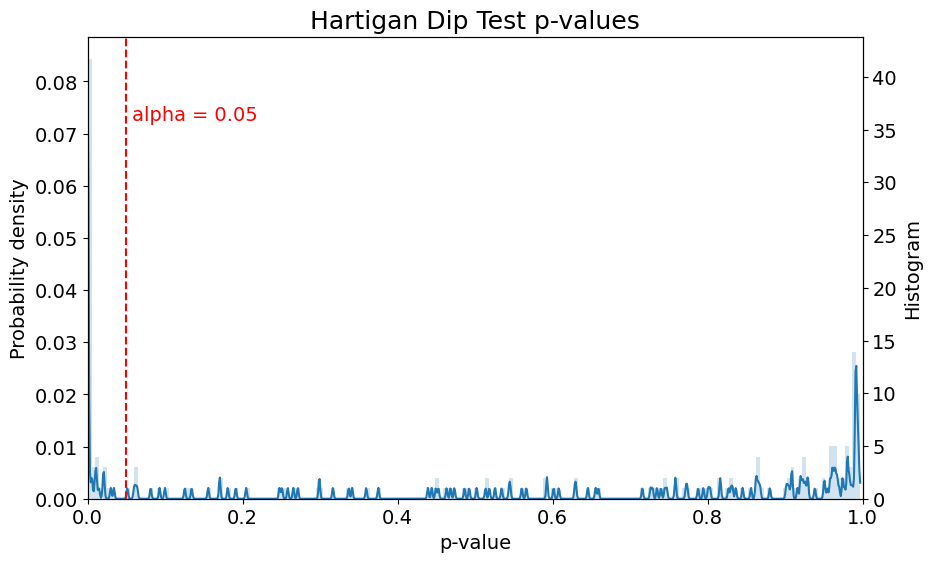

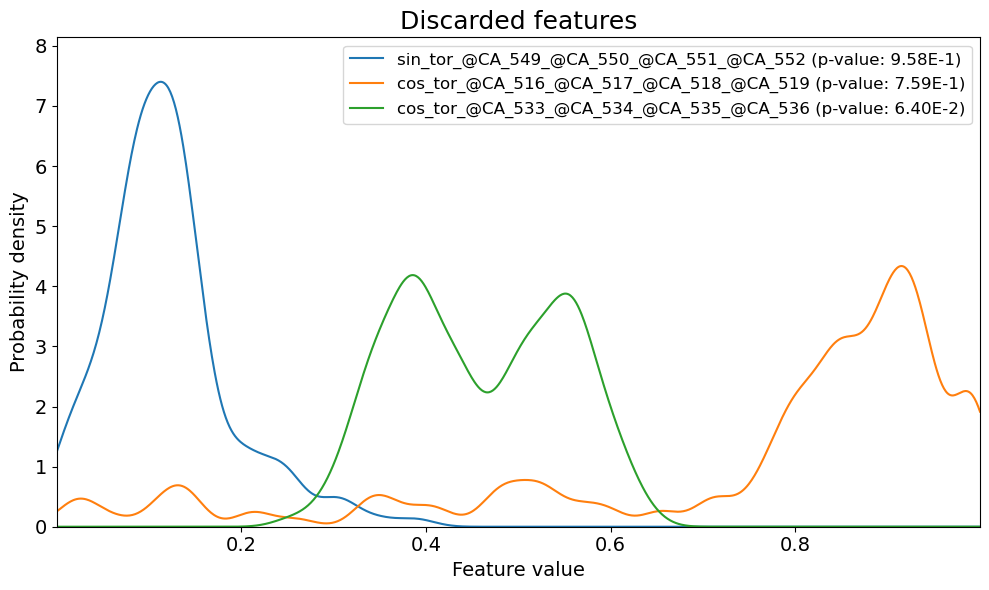

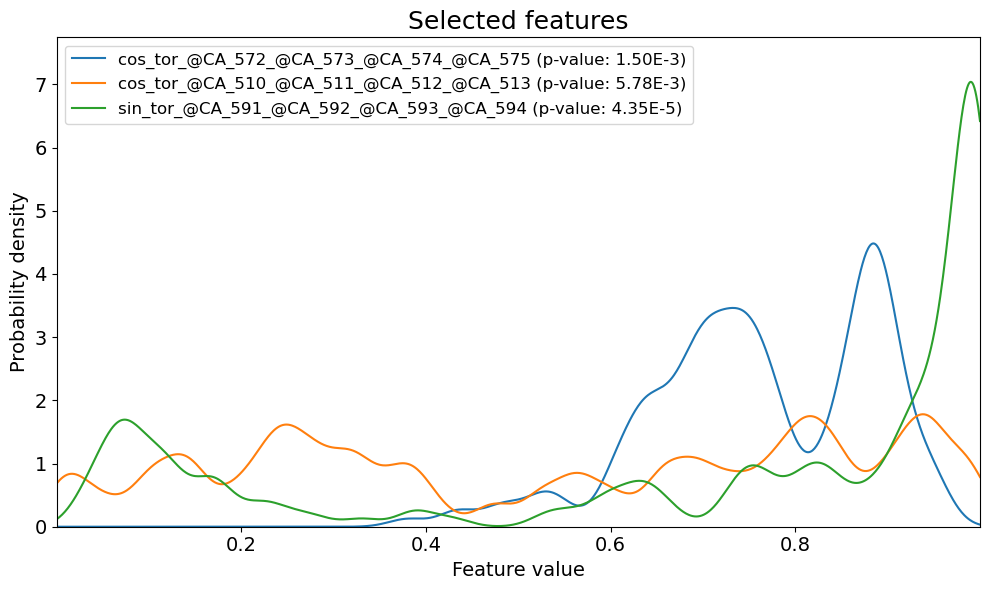

In [3]:
from deep_cartograph import filter_features

# Input configuration
config_path = f"{data_folder}/calpha_transitions/input/torsions_config.yml"

with open(config_path) as config_file:
    configuration = yaml.load(config_file, Loader = yaml.FullLoader)
    
###########################
# Step 2: Filter features #
###########################

# Output folder for this step
step2_folder = os.path.join(output_path, 'filter_features')

# Path to filtered features
filtered_features_path = os.path.join(step2_folder, 'filtered_torsions.txt')

# Clean step folder
if os.path.exists(step2_folder):
    shutil.rmtree(step2_folder)

# Extract configuration for this step
step2_configuration = configuration['filter_features']

# Call API to filter features
filtered_features = filter_features(
    configuration = step2_configuration,
    colvars_path = colvars_path,
    csv_summary = True,
    filtered_features_path = filtered_features_path,
    output_folder = step2_folder)

filter_summary_path = os.path.join(step2_folder, 'filter_summary.csv')
show_filtering_results(colvars_path, filter_summary_path, N = 3, bandwidth = 0.02, kernel = "gaussian")

One can move the cutoff of the p-value to include more or less features.

#### Step 3: Compute Collective Variables

We can use the filtered features to train or compute collective variables that can describe the transition. In this example, we compute a 2 dimensional collective variable using 4 different methods:

- PCA
- tICA
- Autoencoder
- Deep tICA or State free reversible VAMPnets (SRV)

See the corresponding section in the YAML configuration file:

```yaml
train_colvars:
  cvs: ['pca', 'deep_tica', 'tica', 'ae']
  common:
    dimension: 2
    architecture:
      hidden_layers: [5, 3]
      lag_time: 1                        
      pca_lowrank_q: null
    training: 
      general:
        max_tries: 10
        seed: 42
        lengths: [0.8, 0.2]
        batch_size: 256
        max_epochs: 10000
        dropout: 0.1
        shuffle: False
        random_split: True
        check_val_every_n_epoch: 1
        save_check_every_n_epoch: 1
      early_stopping:
        patience: 20
        min_delta: 1.0e-05
      optimizer:
        name: Adam
        kwargs: 
          lr: 1.0e-02 
          weight_decay: 0
      lr_scheduler: null
      save_loss: True
      plot_loss: True
``` 


In [4]:
from deep_cartograph import train_colvars

# Input configuration
config_path = f"{data_folder}/calpha_transitions/input/torsions_config.yml"

with open(config_path) as config_file:
    configuration = yaml.load(config_file, Loader = yaml.FullLoader)
    
#########################
# Step 3: Train colvars #
#########################

# Output folder for this step
step3_folder = os.path.join(output_path, 'train_colvars')

# Clean step folder
if os.path.exists(step3_folder):
    shutil.rmtree(step3_folder)

# Extract configuration for this step
step3_configuration = configuration['train_colvars']

# Call API to train colvars
train_colvars(
    configuration = step3_configuration,
    colvars_path = colvars_path,
    feature_constraints = filtered_features,  
    output_folder = step3_folder,
    trajectory=traj_path,
    topology=top_path)

INFO:deep_cartograph:================================
INFO:deep_cartograph:Training of Collective Variables
INFO:deep_cartograph:================================
INFO:deep_cartograph:Training of collective variables using the mlcolvar library.
INFO:deep_cartograph:Creating datasets from colvars...
INFO:deep_cartograph:Number of samples: 164
INFO:deep_cartograph:Number of features: 54
INFO:deep_cartograph.tools.train_colvars.utils:Calculating PCA...
INFO:deep_cartograph.modules.figures.figures:Computing FES(PC 1, PC 2)...
/home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/modules/figures/figures.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize = font_size)
INFO:deep_cartograph.tools.train_colvars.utils:Projecting trajectory...
INFO:deep_cartograph.modules.statistics.statistics:Best number of clusters: 8
/home/pnavar

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

#### PCA

The projection of the trajectory onto the first two principal components is shown below.

In [5]:
show_results(output_path, model_name = 'pca')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3


#### AE

In [6]:
show_results(output_path, model_name = 'ae')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3
Final model score: 3.4725E-2


- When all the points are on the diagonal, it means that both components of the AE are the same. A sign that the AE doesn't need two dimensions to describe the transition or that the training could be improved.

#### TICA

In [7]:
show_results(output_path, model_name = 'tica')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3


#### Deep TICA

In [8]:
show_results(output_path, model_name = 'deep_tica')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3
Final model score: -1.8014E+0
Eigenvalue 1: 9.6907E-1
Eigenvalue 2: 9.2858E-1


In [9]:
# Clean previous step folders
if os.path.exists(step1_folder):
    shutil.rmtree(step1_folder)
if os.path.exists(step2_folder):
    shutil.rmtree(step2_folder)
if os.path.exists(step3_folder):
    shutil.rmtree(step3_folder)

The previous three steps can be run seamlessly using the main API of the package.

In [10]:
features = 'torsions'
run_deep_cartograph(features, system_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of '

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### Using distances as features

In [11]:
features = 'distances'
run_deep_cartograph(features, system_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../../data/calpha_transitions/input/1rcs_B-3ssx_R-3/1rcs_B-3ssx_R-3.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of '

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
show_results(output_folder, model_name = 'pca')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3/distances


In [13]:
show_results(output_folder, model_name = 'ae')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3/distances
Final model score: 1.7695E-2


With the autoencoder now we are not overfitting but underfitting - probably because the relationship between the distances and the conformational change is more complex than with the torsion angles.

In [14]:
show_results(output_folder, model_name = 'tica')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3/distances


In [15]:
show_results(output_folder, model_name = 'deep_tica')

Output folder: ../../../data/calpha_transitions/output/1rcs_B-3ssx_R-3/distances
Final model score: -2.0030E+0
Eigenvalue 1: 1.0073E+0
Eigenvalue 2: 9.9418E-1


## 2olu_A-2olv_A-1 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/2olu_A-2olv_A-1/trajectory.mp4" controls> </video>
</center>

In [16]:
features = 'torsions'
system_name = '2olu_A-2olv_A-1'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../../data/calpha_transitions/input/2olu_A-2olv_A-1/2olu_A-2olv_A-1.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of '

Results for model: pca
Output folder: ../../../data/calpha_transitions/output/2olu_A-2olv_A-1/torsions


Results for model: ae
Output folder: ../../../data/calpha_transitions/output/2olu_A-2olv_A-1/torsions
Final model score: 7.6054E-3


Results for model: tica
Output folder: ../../../data/calpha_transitions/output/2olu_A-2olv_A-1/torsions


Results for model: deep_tica
Output folder: ../../../data/calpha_transitions/output/2olu_A-2olv_A-1/torsions
Final model score: -1.7841E+0
Eigenvalue 1: 9.7171E-1
Eigenvalue 2: 9.1645E-1


<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
features = 'distances'
system_name = '2olu_A-2olv_A-1'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: ../../data/calpha_transitions/input/2olu_A-2olv_A-1/2olu_A-2olv_A-1.dcd
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/shared/work/pnavarro/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.w

## 3cw2_E-2qmu_A-3 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/3cw2_E-2qmu_A-3/trajectory.mp4" controls> </video>
</center>

In [ ]:
features = 'torsions'
system_name = '3cw2_E-2qmu_A-3'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

In [ ]:
features = 'distances'
system_name = '3cw2_E-2qmu_A-3'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

## 3hif_B-4bhp_A-3 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/3hif_B-4bhp_A-3/trajectory.mp4" controls> </video>
</center>

In [ ]:
features = 'torsions'
system_name = '3hif_B-4bhp_A-3'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

In [ ]:
features = 'distances'
system_name = '3hif_B-4bhp_A-3'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

## 3ts7_B-3ts7_A-1 transition

<center>
    <video width="620" height="440" src="../../data/calpha_transitions/input/3ts7_B-3ts7_A-1/trajectory.mp4" controls> </video>
</center>

In [ ]:
features = 'torsions'
system_name = '3ts7_B-3ts7_A-1'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)

In [ ]:
features = 'distances'
system_name = '3ts7_B-3ts7_A-1'
output_folder = f"{data_folder}/calpha_transitions/output/{system_name}/{features}"
run_deep_cartograph(features, system_name)

for model in ['pca', 'ae', 'tica', 'deep_tica']:

    print(f"Results for model: {model}")
    show_results(output_folder, model_name = model)